In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import pickle as pkl
import Recordings
import signale, trajectory
import os
from scipy.signal import argrelextrema
from scipy.signal import gaussian
from scipy.stats import pearsonr
import seaborn as sns
import signale.custom_plot as cplot
import matplotlib.patches as mpatches
import pandas as pd

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
sns.set_style('white',{'legend.frameon':True})
colors = ['#FF0000', '#0000FF', '#008000', '#00FFFF', '#FF00FF', '#EE82EE',
        '#808000', '#800080', '#FF6347', '#FFFF00', '#9ACD32', '#4B0082',
        '#FFFACD', '#C0C0C0', '#A0522D', '#FA8072', '#FFEFD5', '#E6E6FA',
        '#F1FAC1', '#C5C5C5', '#A152ED', '#FADD72', '#F0EFD0', '#EEE6FF',
        '#01FAC1', '#F5F5F5', '#A152FF', '#FAFD72', '#F0EFDF', '#EEEFFF',
        '#F1FA99', '#C9C9C9', '#A152DD', '#FA5572', '#FFFFD0', '#EDD6FF']
theme01 = ["#39855f","#ae5dd2","#5cc151","#d049a3","#9ab635","#636ad8",
           "#c7a73a","#8c519c","#4b8e38","#dc3d6f","#64c187","#d84938",
           "#3fc1bf","#e08533","#6175ba","#667228","#d18ed0","#aab069",
           "#a84f77","#60a4da","#a55528","#e48289","#8d6e2d","#ac484d",
           "#da986a"]
theme02 = ["#62c49e","#cb3da4","#5bc34e","#c86ae1","#9fbc34","#8b49b9","#4d922b",
           "#5e6cdb","#e6a83b","#605ea4","#c2b746","#e174ca","#3ac37d","#d53782",
           "#7cb968","#e54172","#3c854c","#e8405a","#47bfd4","#e5552c","#4991cd",
           "#e37d2e","#9095de","#ba9330","#b986dc","#848b2a","#9b438b","#52712a",
           "#de6ba5","#2e886e","#ce2f37","#a6b16c","#b52c49","#70692c","#dd94c7",
           "#bb7525","#a86596","#9a782c","#e76c91","#d0ab6f","#aa385b","#f0a276",
           "#8c435f","#ec7153","#865626","#eb92a2","#b0321e","#e68e83","#a94e1d",
           "#ba6371","#ab774c","#d95a5b","#cd7f53","#a75143","#e07669"]

In [4]:
def MA(array,ord=2):
    ma = np.array([array[ii-ord/2:ii+ord/2].mean() for ii in range(array.size) if ii >= ord ],dtype=float)
    ma = np.insert(ma,0,array[0:ord/2])
    ma = np.append(ma,array[-(ord/2)-1:-1])
    return ma
def zScore(array):
    return(array - np.average(array))/ np.std(array)

def nvt_loader(filename):
    """ 
    Memory map the Neuralynx .nvt format
    Fields
    -------
    swstx
    swid
    sw_data_size
    qTimeStamps       Cheetah timestamp for this record. This value is in microseconds.
    dwpoints          Points with the color bitfield values for this record.This is a 400
                      element array.  See Video Tracker in reference. 
    sncrc
    dnextracted_x     Extracted X location of the target being tracked. 
    dnextracted_y     Extracted Y location of the target being tracked.
    dnextracted_angle The calculated head angle in degrees clockwise from the positive Y
                      axis. Zero will be assigned if angle tracking is disabled.
    dnTargets         Colored targets using the samebitfield format used by the dwPoints array.
                      Instead of transitions, the bitfield indicates the colors that make up 
                      each particular target and the center point of that target.  This is a 50
                      element array sorted by size from largest (index 0) to smallest(index 49).
                      A target value of 0 means that no target is present in thatindex location.
                      See Video Tracker Bitfield Information in reference. 
    
    Reference:
    ----------
        http://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """ 
    nev_dtype = np.dtype([
        ('swstx'              , '<i2'),
        ('swid'               , '<i2'),
        ('sw_data_size'       , '<i2'),
        ('qTimeStamps'        , '<u8'),
        ('dwPoints'           , '<u4',(400,)),
        ('sncrc'              , '<i2'),
        ('dnextracted_x'      , '<i4'),
        ('dnextracted_y'      , '<i4'),
        ('dnextracted_angle'  , '<i4'),
        ('dnTargets'          , '<i4',(50,)),
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='readwrite',
       offset=(16 * 2**10))

def subsequence(sub,ref):
    '''
    A function to determine the number of specefic sequence repeated within a larger sequence.
    
    Parameters:
    sub:
    ref:
    
    
    Returns:
    idx : This an array containing the index of elements of sub in the ref! if idx is stricktly increasing the sequence sub
    is replayed whithin sequence ref!
    '''
    ref = np.array(ref)
    idx = np.array([])
    for ii in range(len(sub)):
        index = np.where(ref == sub[ii])[0]
        if index.size:
            idx = np.append(idx,index)
    idx = np.int0(idx)
    if idx.size:
        return idx, True
    else: 
        return np.array([]) , False
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
def coincidence(spikes):
    spikes.burstDetector()
    spikes.MuaDetector()
    mua = spikes.MultiUnitFiring
    ccdc = []
    for k in range(len(spikes)):
        for i in range(spikes[k].spike_times.size):
            less = np.where(mua[:, 0] < spikes[k].spike_times[i])[0]  # Ripples started before spike!    
            more = np.where(mua[:, 1] > spikes[k].spike_times[i])[0]  # Ripples ended after spike!
            mua_idx = np.intersect1d(less, more)  # index of the ripple covering the spike!
            if mua_idx.size:
                ccdc.append([k, i, mua_idx])
    ccdc = np.array(ccdc)
    ccdc = ccdc[np.argsort(ccdc[:, 2])]  # sorting w.r.t ripple index  
    spikes.overlap = ccdc
def MUA(spikes):

        if not hasattr(spikes, 'overlap'):
            print 'There is no overlap detected between spikes and ripples, calculating using default arguments...'
            spikes.coincidence()
        mua = []  # Multi Unit Activity
        bursts = []  # This keeps the firing activity(>=2spikes) during ripples
        repetition = []  # Contains the number of spikes in each ripple!
        ripp_set = set(spikes.overlap[:, 2])  # Keeps the tags of ripples containing MUA! 
        
        for item in ripp_set:
            repetition.append([item, np.where(spikes.overlap[:, 2] == item)[0].size])
        repetition = np.array(repetition)
        spikes.rippleSpikeContent = repetition
        
        for item in repetition[:, 0]:
            activity_block = spikes.overlap[np.where(spikes.overlap[:, 2] == item)]
            if not activity_block[:, 0].mean() == activity_block[0, 0]:
                mua.append(activity_block)
        spikes.MultiUnitActivity = mua
def sequencing(spikes):
        '''
        This function sequences the events detected by MUA() function
        
        Parameters
        ----------
        Returns
        ----------
        sequence_1st_spike : 
        sequence_median :
        
        See also
        ----------
        coincidence, MUA
        
        Notes
        ----------
         It takes the result of MUA function as input.
        '''
        fst_spk_sq = []
        median_sq = []  # Sequences based on first spike times!
        for item in spikes.MultiUnitActivity:
            cells = set(item[:, 0])
            sequence = []
            for jtem in cells:
                row_idx = np.where(item[:, 0] == jtem)[0]
                spk_times = spikes[jtem].spike_times[item[row_idx, 1]]  # This returns the spike times of a specific cell.
                sequence.append([jtem, spk_times.min(), np.median(spk_times), spk_times.size, item[0, 2]]) #No use for the last 2! Why did i put them there?
            sequence = np.array(sequence)
            sequence = sequence[np.argsort(sequence[:, 1])]
            fst_spk_sq.append(sequence)
            sequence = sequence[np.argsort(sequence[:, 2])]
            median_sq.append(sequence)
        spikes.sequence_1st_spike = fst_spk_sq
        spikes.sequence_median = median_sq

In [5]:
animalPath = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3903/LinearTrack_05-11-16_Day3/'
placeCellList = animalPath + 'parrentData/placeCells.spk'
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat3903Lesion/dataFiles/'


In [6]:
pllSpikeTrain = pkl.load(open(placeCellList,'rb'))
pllSpikeTrain.changeTimeUnit('ms')
LTtimes = pkl.load(open(animalPath+'02-begin1/CSC10.lfp')).timeAxis[[0,-1]]
sleepPreTrain = pllSpikeTrain.time_slice(pllSpikeTrain.t_start,LTtimes[0])
sleepPostTrain = pllSpikeTrain.time_slice(LTtimes[1],pllSpikeTrain.t_stop)
sleepEpochs = pd.read_pickle('dataFiles/sleepDB/SleepEpoch-Rat3903-Day3.db')
del pllSpikeTrain
#del traj
animal = 'rat3903D3'
fileBases = ['pre','post']
sessions = [sleepPreTrain,sleepPostTrain]
####Day1
leftFields  = pkl.load(open(dataFolder+'LtemplateD1.nparr'))
rightFields = pkl.load(open(dataFolder+'RtemplateD1.nparr'))

In [7]:
sleepPreTrain.binwidth = 1
sleepPreTrain.calcTimeAxis()
sleepPreTrain.burstDetector(kernel_width=20)
sleepPreTrain.MuaDetector()
sleepPostTrain.binwidth = 1
sleepPostTrain.calcTimeAxis()
sleepPostTrain.burstDetector(kernel_width=20)
sleepPostTrain.MuaDetector()

There is no spiketrain at the moment... 
              Calculating spike trains by covolving with a Gaussian kernel of sigma = 5 ms
There is no spiketrain at the moment... 
              Calculating spike trains by covolving with a Gaussian kernel of sigma = 5 ms


In [8]:
popDB = pd.DataFrame([],columns=[u't_start', u't_end', u'peak_value', u't_peak', u'Lcorr', u'Rcorr',
                                 u'Lpv',u'Rpv',u'tSub',u'lSub',u'rSub',u'epoch', u'date',u'session',
                                 u'animal'])
sleepEpochs1 = sleepEpochs[sleepEpochs.session=='sleep01']
expDate = sleepEpochs1.date[0]
animal = sleepEpochs1.animal[0]
session = sleepEpochs1.session[0]
popDF = pd.DataFrame(sleepPreTrain.MultiUnitFiring/1e3,columns=['t_start', 't_end','peak_value', 't_peak'])
popDF['Lcorr'] = popDF.shape[0]*[0.0]
popDF['Rcorr'] = popDF.shape[0]*[0.0]
popDF['Lpv'] = popDF.shape[0]*[1.0]
popDF['Rpv'] = popDF.shape[0]*[1.0]
popDF['tSub'] = popDF.shape[0]*[0.0]
popDF['lSub'] = popDF.shape[0]*[0.0]
popDF['rSub'] = popDF.shape[0]*[0.0]
popDF['epoch'] = sleepPreTrain.MultiUnitFiring.shape[0]*['NA']
for ii,item in sleepEpochs1[sleepEpochs1.epoch=='SWS'].iterrows():
    before = (popDF.t_peak) < item[1]
    after = (popDF.t_peak ) > item[0]
    inBetween = np.logical_and(before,after)
    Nep = popDF['epoch'][inBetween].size
    popDF['epoch'][inBetween] = Nep * ['sws']
for ii,item in sleepEpochs1[sleepEpochs1.epoch=='REM'].iterrows():
    before = (popDF.t_peak) < item[1]
    after = (popDF.t_peak ) > item[0]
    inBetween = np.logical_and(before,after)
    Nep = popDF['epoch'][inBetween].size
    popDF['epoch'][inBetween] = Nep * ['rem']
for ii,item in sleepEpochs1[sleepEpochs1.epoch=='AWAKE'].iterrows():
    before = (popDF.t_peak) < item[1]
    after = (popDF.t_peak ) > item[0]
    inBetween = np.logical_and(before,after)
    Nep = popDF['epoch'][inBetween].size
    popDF['epoch'][inBetween] = Nep * ['awake']
popDF['date'] = popDF.shape[0]*[expDate]
popDF['session'] = popDF.shape[0]*[session]
popDF['animal'] = popDF.shape[0]*[animal]
print 'I......................................'
###################################
####Adding rank-order correlations
###################################
for ii,row in popDF.iterrows():
    ti = 1e3*row.t_start
    tf = 1e3*row.t_end
    evIds = []
    for cellID in sleepPreTrain.id_list:
        spk = sleepPreTrain[cellID]
        inWindowSpikes = np.logical_and(spk.spike_times > ti,spk.spike_times < tf)
        evIds.append(spk.spike_times[inWindowSpikes].mean())
    Npcells = np.logical_not(np.isnan(evIds)).sum()
    timeSortedIds =  np.argsort(evIds)[:Npcells]
    Lsub = subsequence(timeSortedIds,leftFields)[0]
    Rsub = subsequence(timeSortedIds,rightFields)[0]
    #print Lsub
    if Lsub.size > 3:
        Lr = pearsonr(range(Lsub.size),np.argsort(Lsub))[0]#Lr = pearsonr(Lsub,sorted(Lsub))[0]
    else: 
        Lr = None
    if Rsub.size > 3:
        Rr = pearsonr(range(Rsub.size),np.argsort(Rsub))[0]#Rr = pearsonr(Rsub,sorted(Rsub))[0]
    else:
        Rr = None
    popDF.Lcorr[ii]= Lr
    popDF.Rcorr[ii]= Rr
    popDF.tSub[ii] = timeSortedIds.size
    popDF.lSub[ii] = Lsub.size
    popDF.rSub[ii] = Rsub.size
popDB = popDB.append(popDF,ignore_index=True)

###################################################################################################################
###################################################################################################################

sleepEpochs2 = sleepEpochs[sleepEpochs.session=='sleep02']
session = sleepEpochs2.session[sleepEpochs2.index[0]]
popDF = pd.DataFrame(sleepPostTrain.MultiUnitFiring/1e3,columns=['t_start', 't_end','peak_value', 't_peak'])
popDF['Lcorr'] = popDF.shape[0]*[0.0]
popDF['Rcorr'] = popDF.shape[0]*[0.0]
popDF['Lpv'] = popDF.shape[0]*[1.0]
popDF['Rpv'] = popDF.shape[0]*[1.0]
popDF['tSub'] = popDF.shape[0]*[0.0]
popDF['lSub'] = popDF.shape[0]*[0.0]
popDF['rSub'] = popDF.shape[0]*[0.0]
popDF['epoch'] = sleepPostTrain.MultiUnitFiring.shape[0]*['NA']
for ii,item in sleepEpochs2[sleepEpochs2.epoch=='SWS'].iterrows():
    before = (popDF.t_peak) < item[1]
    after = (popDF.t_peak ) > item[0]
    inBetween = np.logical_and(before,after)
    Nep = popDF['epoch'][inBetween].size
    popDF['epoch'][inBetween] = Nep * ['sws']
for ii,item in sleepEpochs2[sleepEpochs2.epoch=='REM'].iterrows():
    before = (popDF.t_peak) < item[1]
    after = (popDF.t_peak ) > item[0]
    inBetween = np.logical_and(before,after)
    Nep = popDF['epoch'][inBetween].size
    popDF['epoch'][inBetween] = Nep * ['rem']
for ii,item in sleepEpochs2[sleepEpochs2.epoch=='AWAKE'].iterrows():
    before = (popDF.t_peak) < item[1]
    after = (popDF.t_peak ) > item[0]
    inBetween = np.logical_and(before,after)
    Nep = popDF['epoch'][inBetween].size
    popDF['epoch'][inBetween] = Nep * ['awake']
popDF['date'] = popDF.shape[0]*[expDate]
popDF['session'] = popDF.shape[0]*[session]
popDF['animal'] = popDF.shape[0]*[animal]
print 'I......................................'
###################################
####Adding rank-order correlations
###################################
for ii,row in popDF.iterrows():
    ti = 1e3*row.t_start
    tf = 1e3*row.t_end
    evIds = []
    for cellID in sleepPostTrain.id_list:
        spk = sleepPostTrain[cellID]
        inWindowSpikes = np.logical_and(spk.spike_times > ti,spk.spike_times < tf)
        evIds.append(spk.spike_times[inWindowSpikes].mean())
    Npcells = np.logical_not(np.isnan(evIds)).sum()
    timeSortedIds =  np.argsort(evIds)[:Npcells]
    Lsub = subsequence(timeSortedIds,leftFields)[0]
    Rsub = subsequence(timeSortedIds,rightFields)[0]
    #print Lsub
    if Lsub.size > 3:
        Lr = pearsonr(range(Lsub.size),np.argsort(Lsub))[0]#Lr = pearsonr(Lsub,sorted(Lsub))[0]
    else: 
        Lr = None
    if Rsub.size > 3:
        Rr = pearsonr(range(Rsub.size),np.argsort(Rsub))[0]#Rr = pearsonr(Rsub,sorted(Rsub))[0]
    else:
        Rr = None
    popDF.Lcorr[ii]= Lr
    popDF.Rcorr[ii]= Rr
    popDF.tSub[ii] = timeSortedIds.size
    popDF.lSub[ii] = Lsub.size
    popDF.rSub[ii] = Rsub.size
popDB = popDB.append(popDF,ignore_index=True)

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.w

I......................................
I......................................

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,t_start,t_end,peak_value,t_peak,Lcorr,Rcorr,Lpv,Rpv,tSub,lSub,rSub,epoch,date,session,animal
0,12.9855,13.0405,0.004619,13.0105,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903
1,17.0475,17.0885,0.002841,17.0635,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903
2,20.6715,20.7105,0.002880,20.6905,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903
3,25.8785,25.9335,0.004489,25.9055,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903
4,30.5385,30.6095,0.003148,30.5775,NaN,NaN,1,1,3,3,3,awake,Day3,sleep01,Rat3903
5,42.8565,42.9065,0.003160,42.8715,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903
6,45.1785,45.2565,0.003475,45.2035,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903
7,50.7965,50.8725,0.002687,50.8515,NaN,NaN,1,1,3,3,3,awake,Day3,sleep01,Rat3903
8,51.2865,51.3335,0.003788,51.3065,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903
9,51.5085,51.5525,0.003580,51.5285,NaN,NaN,1,1,2,2,2,awake,Day3,sleep01,Rat3903


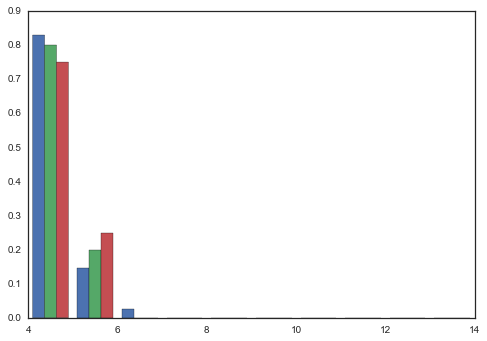

In [9]:
popDB.to_pickle(dataFolder+'sleepDB/3903-popDB-D3.db')
pl.hist([popDB[popDB.epoch=='sws'].tSub,popDB[popDB.epoch=='rem'].tSub,popDB[popDB.epoch=='NA'].tSub],np.arange(4,15),normed=True)
popDB